In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import gc
from  datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split

In [46]:
import warnings 
warnings.filterwarnings('ignore')

In [47]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [48]:
#Import DataFrames.
sales=pd.read_csv('sales_train_evaluation.csv')
#sales=reduce_mem_usage(sales)
#sales=pd.read_csv('sales_train_validation.csv')
#sales=reduce_mem_usage(sales)

In [49]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


In [50]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [51]:
day=[col for col in sales.columns if 'd_' in col]
#day

In [8]:
sales['sales_sum'] = sales[[col for col in sales.columns if 'd_' in col]].sum(axis=1)

In [9]:
#sort= sales.groupby('sales_sum', sort=False).sum()
#sort.sort_index(ascending=False)
#grouped = df.groupby('mygroups', sort=False).sum()
#grouped.sort_index(ascending=False)
#df.groupby('group')['id'].count().sort_values(ascending=False)
#sort=sales.groupby('item_id')['sales_sum'].sum().sort_values(ascending=False)
#sort
#sort.loc[[0]]
#print(df.loc[[159220]])

In [10]:
#df.groupby(['name','otherstuff1','otherstuff2'],as_index=False).sum()
#sales.groupby(['item_id','dept_id', 'cat_id']).sum().sort_values('sales_sum', ascending=False)


In [11]:
    sorted_sales=sales.groupby(['item_id','dept_id', 'cat_id']).sum().sort_values('sales_sum', ascending=False)
    sorted_sales

,,,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,sales_sum
item_id,dept_id,cat_id,,,,,,,,,,,,,,,,,,,,,
FOODS_3_090,FOODS_3,FOODS,1046,1036,673,642,531,877,1117,1311,1306,517,...,736,675,374,369,380,400,626,682,679,1017916
FOODS_3_586,FOODS_3,FOODS,516,479,328,376,319,430,405,624,537,432,...,499,556,364,415,375,334,451,498,583,932236
FOODS_3_252,FOODS_3,FOODS,289,273,157,172,132,218,227,363,255,204,...,430,378,272,318,330,225,309,345,416,573723
FOODS_3_555,FOODS_3,FOODS,321,315,214,204,159,265,240,425,355,224,...,256,269,209,188,215,212,279,295,320,497881
FOODS_3_587,FOODS_3,FOODS,298,353,234,310,205,214,190,572,508,428,...,233,352,233,160,190,170,216,240,294,402159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOBBIES_2_084,HOBBIES_2,HOBBIES,0,0,0,0,0,0,0,0,0,0,...,3,3,2,0,1,1,0,0,1,786
HOUSEHOLD_2_005,HOUSEHOLD_2,HOUSEHOLD,0,0,0,0,0,0,0,0,0,0,...,1,2,1,0,0,3,1,1,1,782
HOUSEHOLD_2_175,HOUSEHOLD_2,HOUSEHOLD,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,4,3,0,0,1,759


In [12]:
sorted_sales = sorted_sales.reset_index()

In [13]:
#sorted_sales.iloc[4, :-1].plot()

In [14]:
sorted_sales.to_csv('sorted_sales.csv', index=False)

In [15]:
calendar=pd.read_csv('calendar.csv')
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [16]:
calendar=reduce_mem_usage(calendar)

Mem. usage decreased to  0.12 Mb (41.9% reduction)


In [17]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int16 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int8  
 4   month         1969 non-null   int8  
 5   year          1969 non-null   int16 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int8  
 12  snap_TX       1969 non-null   int8  
 13  snap_WI       1969 non-null   int8  
dtypes: int16(2), int8(5), object(7)
memory usage: 125.1+ KB


In [18]:
sales_df = sorted_sales.set_index('item_id')[day].T\
    .merge(calendar.set_index('d')['date'],
          left_index=True,
          right_index=True,
          validate='1:1')\
    .set_index('date')
sales_df.index = pd.to_datetime(sales_df.index)
sales_df.head()

,FOODS_3_090,FOODS_3_586,FOODS_3_252,FOODS_3_555,FOODS_3_587,FOODS_3_714,FOODS_3_694,FOODS_3_226,FOODS_3_202,FOODS_3_120,...,HOUSEHOLD_2_060,HOUSEHOLD_2_307,HOUSEHOLD_2_130,HOUSEHOLD_2_245,HOBBIES_2_111,HOBBIES_2_084,HOUSEHOLD_2_005,HOUSEHOLD_2_175,HOBBIES_2_119,HOUSEHOLD_2_101
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,1046,516,289,321,298,238,291,210,106,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-30,1036,479,273,315,353,215,230,168,113,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-31,673,328,157,214,234,141,187,119,65,0,...,0,0,0,0,0,0,0,0,0,0
2011-02-01,642,376,172,204,310,144,200,165,80,0,...,0,0,0,0,0,0,0,0,0,0
2011-02-02,531,319,132,159,205,96,136,116,75,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1941 entries, 2011-01-29 to 2016-05-22
Columns: 3049 entries, FOODS_3_090 to HOUSEHOLD_2_101
dtypes: int64(3049)
memory usage: 45.2 MB


In [20]:
sales_df.shape

(1941, 3049)

In [27]:
#train_df = sales_df[-1000:-100]
#val_df = sales_df[-100:]
train_df = sales_df[-100:-30]
val_df = sales_df[-30:]

In [35]:
train_df['FOODS_3_090']

date
2016-02-13    799
2016-02-14    677
2016-02-15    482
2016-02-16    444
2016-02-17    487
             ... 
2016-04-18    486
2016-04-19    424
2016-04-20    425
2016-04-21    422
2016-04-22    629
Name: FOODS_3_090, Length: 70, dtype: int64

In [29]:
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train, c='blue')
    plt.plot(test, c='orange');

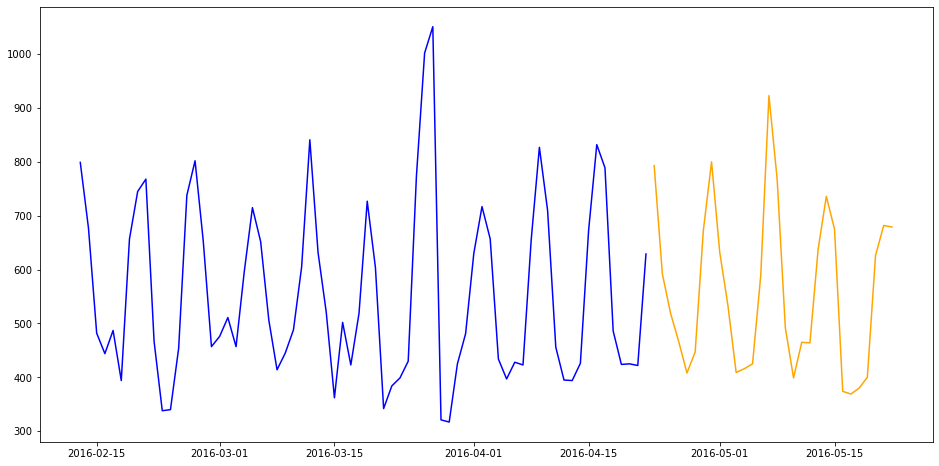

In [36]:
# This plot confirms that our function works properly.
# The gap between the train and test is to be expected
# because we aren't connecting the dots between our
# 107th and 108th observations.

train_test_plot(train_df['FOODS_3_090'], val_df['FOODS_3_090'])

#### The Augmented Dicky-Fuller test
Tests for trend non-stationary<br>
Null hypothesis is time series is non-stationary

In [544]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_df[train_df.columns[0]])
print('Test Statistic : ',result[0])
print('P-value : ',np.round(result[1],decimals=15))

Test Statistic :  -5.458171351883213
P-value :  2.553780396e-06


T-statistic = -5.17, More negative means likey to be stationary
P-value < 0.05, Hence we reject the Null hypothesis that Time series is non-Stationary, which concludes that our data is stationary

In [ ]:
print(f'Autocorrelation between Weekly Sales and 1-lag Weekly_Sales: {round(train_df["FOODS_3_090"].autocorr(lag=1),4)}')
print(f'Autocorrelation between Weekly Sales and 10-lag Weekly_Sales: {round(train_df["FOODS_3_090"].autocorr(lag=10),4)}')
print(f'Autocorrelation between Weekly Sales and 52-lag Weekly_Sales: {round(train_df["FOODS_3_090"].autocorr(lag=52),4)}')

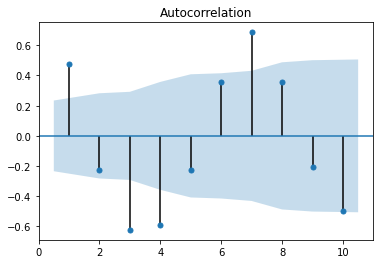

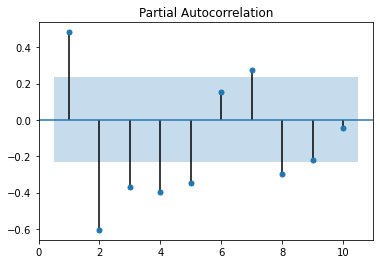

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_ = plot_acf(train_df[train_df.columns[0]], lags=10, zero=False, alpha=0.05)
_ = plot_pacf(train_df[train_df.columns[0]], lags=10, zero=False, alpha=0.05)

In [546]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order_aic_bic = []
# Loop over AR order
for p in range(3):
    #Loop over MA order
    for q in range(3):
        try:
            model = SARIMAX(train_df[train_df.columns[0]],order=(p,0,q))
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            order_aic_bic.append((p, q, None, None))

order_df = pd.DataFrame(order_aic_bic, columns=['p','q','aic','bic'])

order_df

,p,q,aic,bic
0,0,0,14110.483267,14115.285662
1,0,1,13198.235377,13207.840167
2,0,2,12815.827485,12830.234669
3,1,0,12163.555494,12173.160283
4,1,1,12164.981907,12179.389092
5,1,2,12097.931518,12117.141097
6,2,0,12165.222760,12179.629945
7,2,1,12148.925838,12168.135417
8,2,2,12080.951007,12104.962981


Both AIC & BIC values were found to be lowest for AR order(p)=1 and MA order(q)=2

Mean Absoulte Error :  119.41175183907465


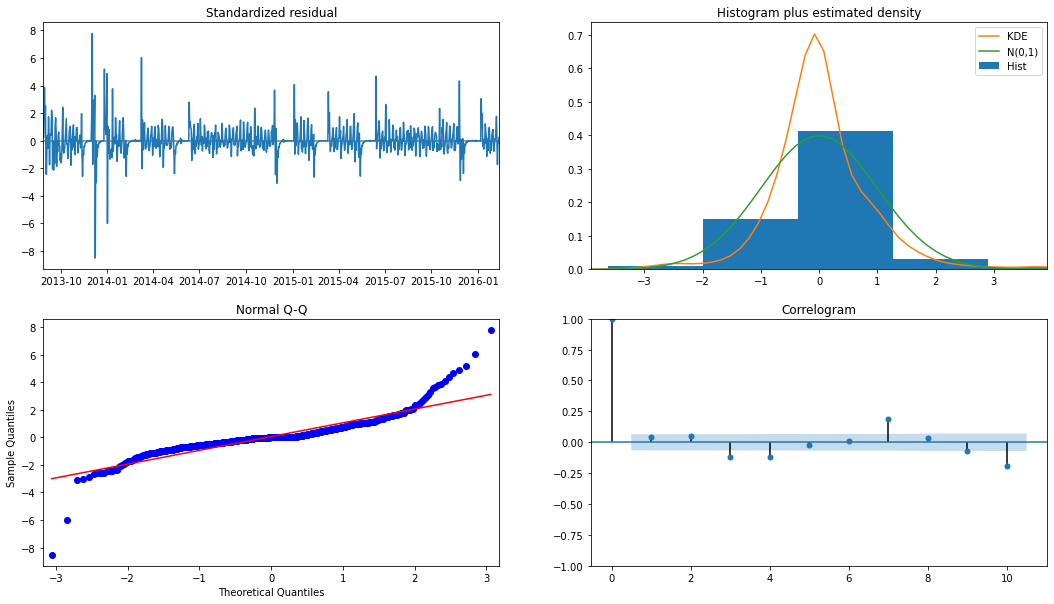

In [547]:
model = SARIMAX(train_df[train_df.columns[0]],order=(1,0,2))
results = model.fit()

residuals = results.resid
# Mean Absolute Error
mae = np.mean(np.abs(residuals))
print('Mean Absoulte Error : ', mae)


results.plot_diagnostics(figsize=(18,10))
_ = plt.show()

Observations :<br>
Standardize Residuals: There is no obvious structure in the residuals, hence our model has worked correctly<br>
Histogram plus estimated Density: The green and orange lines are almost the same, hence our model is good<br>
Normal Q-Q: The dots are aligned with the red line, which states that our model residuals are normally distributed<br>
Correlogram: There is no significant correlation in the residuals, it means that our model has captured most of the information in the data that is required

In [548]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            FOODS_3_090   No. Observations:                  900
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -6044.966
Date:                Sat, 13 Feb 2021   AIC                          12097.932
Time:                        20:11:02   BIC                          12117.141
Sample:                    08-27-2013   HQIC                         12105.270
                         - 02-12-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9878      0.005    210.108      0.000       0.979       0.997
ma.L1         -0.1339      0.022     -6.143      0.000      -0.177      -0.091
ma.L2         -0.3578      0.021    -16.702      0.000      -0.400      -0.316
sigma2      3.983e+04    679.085     58.652      0.000    3.85e+04    4.12e+04
===================================================================================
Ljung-Box (Q):                      371.05   Jarque-Bera (JB):              8798.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [549]:
predictions = []

for idx in range(3):
    model = SARIMAX(train_df[train_df.columns[idx]],order=(1,0,2))
    results = model.fit()
    predictions.append(results.forecast(30))

predictions = np.array(predictions).reshape((-1, 30))

In [550]:
predictions = []


model = SARIMAX(train_df,order=(1,0,2), seasonal_order=(2,2,0,12), trend='c')
results = model.fit()
predictions = results.forecast(11)

ValueError: SARIMAX models require univariate `endog`. Got shape (900, 3049).

In [ ]:
fig = make_subplots(rows=3, cols=1)

for idx in range(3):
    fig.add_trace(go.Scatter(x=train_df.index, y=train_df[train_df.columns[idx]]), row=idx+1, col=1)
    fig.add_trace(go.Scatter(x=val_df.index, y=val_df[val_df.columns[idx]]), row=idx+1, col=1)
    fig.add_trace(go.Scatter(x=val_df.index, y=predictions[idx]), row=idx+1, col=1)
    
fig.update_layout(height=900, width=900, title_text="Predictions ARIMA", template='plotly_white')

In [539]:
sales_df.dtypes

FOODS_3_090        int64
FOODS_3_586        int64
FOODS_3_252        int64
FOODS_3_555        int64
FOODS_3_587        int64
                   ...  
HOBBIES_2_084      int64
HOUSEHOLD_2_005    int64
HOUSEHOLD_2_175    int64
HOBBIES_2_119      int64
HOUSEHOLD_2_101    int64
Length: 3049, dtype: object

In [ ]:
sorted_sales.index = pd.to_datetime(sorted_sales.index)

In [366]:
sorted_sales.columns

Index(['FOODS_3_090', 'FOODS_3_586', 'FOODS_3_252', 'FOODS_3_555',
       'FOODS_3_587', 'FOODS_3_714', 'FOODS_3_694', 'FOODS_3_226',
       'FOODS_3_202', 'FOODS_3_120',
       ...
       'HOUSEHOLD_2_060', 'HOUSEHOLD_2_307', 'HOUSEHOLD_2_130',
       'HOUSEHOLD_2_245', 'HOBBIES_2_111', 'HOBBIES_2_084', 'HOUSEHOLD_2_005',
       'HOUSEHOLD_2_175', 'HOBBIES_2_119', 'HOUSEHOLD_2_101'],
      dtype='object', length=3049)

In [81]:
price=pd.read_csv('sell_prices.csv')
price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [82]:
price=reduce_mem_usage(price)

Mem. usage decreased to 72.33 Mb (30.0% reduction)


In [83]:
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2708822 entries, 0 to 2708821
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int16  
 3   sell_price  float16
dtypes: float16(1), int16(1), object(2)
memory usage: 72.3+ MB


In [84]:
price.isnull().sum()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

In [87]:
calendar.isnull().sum()

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [88]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [89]:
calendar.drop(columns=['snap_WI','snap_TX'], inplace=True)

In [90]:
sample=pd.read_csv('sample_submission.csv')


In [91]:
sample1=sample.loc[0:12195]

In [92]:
sample2=sample.loc[30490:42685]

In [93]:
sample = pd.concat([sample1,sample2], axis = 0)

In [94]:
sample=reduce_mem_usage(sample)

Mem. usage decreased to  1.02 Mb (81.7% reduction)


In [95]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24392 entries, 0 to 42685
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      24392 non-null  object
 1   F1      24392 non-null  int8  
 2   F2      24392 non-null  int8  
 3   F3      24392 non-null  int8  
 4   F4      24392 non-null  int8  
 5   F5      24392 non-null  int8  
 6   F6      24392 non-null  int8  
 7   F7      24392 non-null  int8  
 8   F8      24392 non-null  int8  
 9   F9      24392 non-null  int8  
 10  F10     24392 non-null  int8  
 11  F11     24392 non-null  int8  
 12  F12     24392 non-null  int8  
 13  F13     24392 non-null  int8  
 14  F14     24392 non-null  int8  
 15  F15     24392 non-null  int8  
 16  F16     24392 non-null  int8  
 17  F17     24392 non-null  int8  
 18  F18     24392 non-null  int8  
 19  F19     24392 non-null  int8  
 20  F20     24392 non-null  int8  
 21  F21     24392 non-null  int8  
 22  F22     24392 non-null

In [96]:
sample.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
sample.isnull().sum()

id     0
F1     0
F2     0
F3     0
F4     0
F5     0
F6     0
F7     0
F8     0
F9     0
F10    0
F11    0
F12    0
F13    0
F14    0
F15    0
F16    0
F17    0
F18    0
F19    0
F20    0
F21    0
F22    0
F23    0
F24    0
F25    0
F26    0
F27    0
F28    0
dtype: int64

In [98]:
catcol = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sales= pd.melt(sales, id_vars= catcol, 
               var_name='day', value_name='demand')
sales = reduce_mem_usage(sales)

Mem. usage decreased to 1309.40 Mb (9.4% reduction)


In [99]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
23672431,FOODS_3_823_CA_4_evaluation,FOODS_3_823,FOODS_3,FOODS,CA_4,CA,d_1941,0
23672432,FOODS_3_824_CA_4_evaluation,FOODS_3_824,FOODS_3,FOODS,CA_4,CA,d_1941,0
23672433,FOODS_3_825_CA_4_evaluation,FOODS_3_825,FOODS_3,FOODS,CA_4,CA,d_1941,0
23672434,FOODS_3_826_CA_4_evaluation,FOODS_3_826,FOODS_3,FOODS,CA_4,CA,d_1941,4


In [100]:
test2_rows = [row for row in sample['id'] if 'evaluation' in row]

In [101]:
test2_rows

['HOBBIES_1_001_CA_1_evaluation',
 'HOBBIES_1_002_CA_1_evaluation',
 'HOBBIES_1_003_CA_1_evaluation',
 'HOBBIES_1_004_CA_1_evaluation',
 'HOBBIES_1_005_CA_1_evaluation',
 'HOBBIES_1_006_CA_1_evaluation',
 'HOBBIES_1_007_CA_1_evaluation',
 'HOBBIES_1_008_CA_1_evaluation',
 'HOBBIES_1_009_CA_1_evaluation',
 'HOBBIES_1_010_CA_1_evaluation',
 'HOBBIES_1_011_CA_1_evaluation',
 'HOBBIES_1_012_CA_1_evaluation',
 'HOBBIES_1_013_CA_1_evaluation',
 'HOBBIES_1_014_CA_1_evaluation',
 'HOBBIES_1_015_CA_1_evaluation',
 'HOBBIES_1_016_CA_1_evaluation',
 'HOBBIES_1_017_CA_1_evaluation',
 'HOBBIES_1_018_CA_1_evaluation',
 'HOBBIES_1_019_CA_1_evaluation',
 'HOBBIES_1_020_CA_1_evaluation',
 'HOBBIES_1_021_CA_1_evaluation',
 'HOBBIES_1_022_CA_1_evaluation',
 'HOBBIES_1_023_CA_1_evaluation',
 'HOBBIES_1_024_CA_1_evaluation',
 'HOBBIES_1_025_CA_1_evaluation',
 'HOBBIES_1_026_CA_1_evaluation',
 'HOBBIES_1_027_CA_1_evaluation',
 'HOBBIES_1_028_CA_1_evaluation',
 'HOBBIES_1_029_CA_1_evaluation',
 'HOBBIES_1_03

In [102]:

test2 = sample[sample['id'].isin(test2_rows)]

test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                  'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']

product = sales[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()


test2 = test2.merge(product, how = 'left', on = 'id')


In [103]:
test2

,id,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,...,d_1965,d_1966,d_1967,d_1968,d_1969,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
1,HOBBIES_1_002_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA
2,HOBBIES_1_003_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA
3,HOBBIES_1_004_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA
4,HOBBIES_1_005_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12191,FOODS_3_823_CA_4_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,FOODS_3_823,FOODS_3,FOODS,CA_4,CA
12192,FOODS_3_824_CA_4_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,FOODS_3_824,FOODS_3,FOODS,CA_4,CA
12193,FOODS_3_825_CA_4_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,FOODS_3_825,FOODS_3,FOODS,CA_4,CA
12194,FOODS_3_826_CA_4_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,FOODS_3_826,FOODS_3,FOODS,CA_4,CA


In [104]:
test2 = pd.melt(test2, 
                id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                var_name = 'day', 
                value_name = 'demand')

sales['part'] = 'train'
test2['part'] = 'test'

In [105]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train
...,...,...,...,...,...,...,...,...,...
23672431,FOODS_3_823_CA_4_evaluation,FOODS_3_823,FOODS_3,FOODS,CA_4,CA,d_1941,0,train
23672432,FOODS_3_824_CA_4_evaluation,FOODS_3_824,FOODS_3,FOODS,CA_4,CA,d_1941,0,train
23672433,FOODS_3_825_CA_4_evaluation,FOODS_3_825,FOODS_3,FOODS,CA_4,CA,d_1941,0,train
23672434,FOODS_3_826_CA_4_evaluation,FOODS_3_826,FOODS_3,FOODS,CA_4,CA,d_1941,4,train


In [106]:
test2

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,0,test
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,0,test
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,0,test
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,0,test
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,0,test
...,...,...,...,...,...,...,...,...,...
341483,FOODS_3_823_CA_4_evaluation,FOODS_3_823,FOODS_3,FOODS,CA_4,CA,d_1969,0,test
341484,FOODS_3_824_CA_4_evaluation,FOODS_3_824,FOODS_3,FOODS,CA_4,CA,d_1969,0,test
341485,FOODS_3_825_CA_4_evaluation,FOODS_3_825,FOODS_3,FOODS,CA_4,CA,d_1969,0,test
341486,FOODS_3_826_CA_4_evaluation,FOODS_3_826,FOODS_3,FOODS,CA_4,CA,d_1969,0,test


In [107]:
data = pd.concat([sales,test2], axis = 0)
del sales,test2
gc.collect()

222

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24013924 entries, 0 to 341487
Data columns (total 9 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   id        object
 1   item_id   object
 2   dept_id   object
 3   cat_id    object
 4   store_id  object
 5   state_id  object
 6   day       object
 7   demand    int16 
 8   part      object
dtypes: int16(1), object(8)
memory usage: 1.7+ GB


In [109]:
data.isnull().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
state_id    0
day         0
demand      0
part        0
dtype: int64

In [110]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train


In [111]:
data.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part
341483,FOODS_3_823_CA_4_evaluation,FOODS_3_823,FOODS_3,FOODS,CA_4,CA,d_1969,0,test
341484,FOODS_3_824_CA_4_evaluation,FOODS_3_824,FOODS_3,FOODS,CA_4,CA,d_1969,0,test
341485,FOODS_3_825_CA_4_evaluation,FOODS_3_825,FOODS_3,FOODS,CA_4,CA,d_1969,0,test
341486,FOODS_3_826_CA_4_evaluation,FOODS_3_826,FOODS_3,FOODS,CA_4,CA,d_1969,0,test
341487,FOODS_3_827_CA_4_evaluation,FOODS_3_827,FOODS_3,FOODS,CA_4,CA,d_1969,0,test


In [112]:
data.reset_index(drop=True,inplace=True)
#data = data.loc[12000000:]
calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
data.drop(['d', 'day'], inplace = True, axis = 1)

In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24013924 entries, 0 to 24013923
Data columns (total 15 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   id            object
 1   item_id       object
 2   dept_id       object
 3   cat_id        object
 4   store_id      object
 5   state_id      object
 6   demand        int16 
 7   part          object
 8   date          object
 9   wm_yr_wk      int16 
 10  event_name_1  object
 11  event_type_1  object
 12  event_name_2  object
 13  event_type_2  object
 14  snap_CA       int8  
dtypes: int16(2), int8(1), object(12)
memory usage: 2.4+ GB


In [114]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0


In [115]:
data.isnull().sum()

id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
demand                 0
part                   0
date                   0
wm_yr_wk               0
event_name_1    22038172
event_type_1    22038172
event_name_2    23952944
event_type_2    23952944
snap_CA                0
dtype: int64

In [116]:
data = data.merge(price, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
del calendar,price,product
gc.collect()

80

In [117]:
data.isnull().sum()

id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
demand                 0
part                   0
date                   0
wm_yr_wk               0
event_name_1    22038172
event_type_1    22038172
event_name_2    23952944
event_type_2    23952944
snap_CA                0
sell_price       5113150
dtype: int64

In [118]:
data = data.dropna(axis=0, subset=['sell_price'])

In [119]:
data.isnull().sum()

id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
demand                 0
part                   0
date                   0
wm_yr_wk               0
event_name_1    17344146
event_type_1    17344146
event_name_2    18851361
event_type_2    18851361
snap_CA                0
sell_price             0
dtype: int64

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18900774 entries, 7 to 24013923
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   item_id       object 
 2   dept_id       object 
 3   cat_id        object 
 4   store_id      object 
 5   state_id      object 
 6   demand        int16  
 7   part          object 
 8   date          object 
 9   wm_yr_wk      int16  
 10  event_name_1  object 
 11  event_type_1  object 
 12  event_name_2  object 
 13  event_type_2  object 
 14  snap_CA       int8   
 15  sell_price    float16
dtypes: float16(1), int16(2), int8(1), object(12)
memory usage: 2.0+ GB


In [121]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0.459961
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,1.559570
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,3.169922
11,HOBBIES_1_012_CA_1_evaluation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,5.980469
14,HOBBIES_1_015_CA_1_evaluation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,4,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0.700195


In [122]:
data.dtypes

id               object
item_id          object
dept_id          object
cat_id           object
store_id         object
state_id         object
demand            int16
part             object
date             object
wm_yr_wk          int16
event_name_1     object
event_type_1     object
event_name_2     object
event_type_2     object
snap_CA            int8
sell_price      float16
dtype: object

In [123]:
data.isnull().sum()

id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
demand                 0
part                   0
date                   0
wm_yr_wk               0
event_name_1    17344146
event_type_1    17344146
event_name_2    18851361
event_type_2    18851361
snap_CA                0
sell_price             0
dtype: int64

In [124]:
from sklearn.preprocessing import LabelEncoder
nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for feature in nan_features:
    data[feature].fillna('unknown', inplace = True)

cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for feature in cat:
    encoder = LabelEncoder()
    data[feature] = encoder.fit_transform(data[feature])

In [125]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price
7,HOBBIES_1_008_CA_1_evaluation,1444,3,1,0,0,12,train,2011-01-29,11101,30,4,4,2,0,0.459961
8,HOBBIES_1_009_CA_1_evaluation,1445,3,1,0,0,2,train,2011-01-29,11101,30,4,4,2,0,1.559570
9,HOBBIES_1_010_CA_1_evaluation,1446,3,1,0,0,0,train,2011-01-29,11101,30,4,4,2,0,3.169922
11,HOBBIES_1_012_CA_1_evaluation,1448,3,1,0,0,0,train,2011-01-29,11101,30,4,4,2,0,5.980469
14,HOBBIES_1_015_CA_1_evaluation,1451,3,1,0,0,4,train,2011-01-29,11101,30,4,4,2,0,0.700195


In [126]:
data.dtypes

id               object
item_id           int32
dept_id           int32
cat_id            int32
store_id          int32
state_id          int32
demand            int16
part             object
date             object
wm_yr_wk          int16
event_name_1      int32
event_type_1      int32
event_name_2      int32
event_type_2      int32
snap_CA            int8
sell_price      float16
dtype: object

In [127]:
data['lag_t28'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
data['lag_t29'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(29))
data['lag_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(30))
data['rolling_mean_t7']   = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
data['rolling_std_t7']    = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
data['rolling_mean_t30']  = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())

In [128]:
data = reduce_mem_usage(data)

Mem. usage decreased to 1099.54 Mb (50.4% reduction)


In [129]:
data['rolling_mean_t90']  = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
data['rolling_mean_t180'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
data['rolling_std_t30']   = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
data['rolling_skew_t30']  = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).skew())
data['rolling_kurt_t30']  = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).kurt())

In [130]:
data['lag_price_t1'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1'])
data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)

In [131]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.week
data['day'] = data['date'].dt.day
data['dayofweek'] = data['date'].dt.dayofweek

In [132]:
def weekend(arg):
    if arg==5 or arg==6:
        return 1
    else:
        return 0
data['isweekend'] = data['dayofweek'].apply(weekend)

In [133]:
data['revenue'] = data['demand'] * data['sell_price']
data['lag_revenue_t1'] = data.groupby(['id'])['revenue'].transform(lambda x: x.shift(28))
data['rolling_revenue_std_t28'] = data.groupby(['id'])['lag_revenue_t1'].transform(lambda x: x.rolling(28).std())
data['rolling_revenue_mean_t28'] = data.groupby(['id'])['lag_revenue_t1'].transform(lambda x: x.rolling(28).mean())
data.drop(['revenue'],axis=1,inplace=True)

In [134]:
features = ['item_id', 'cat_id', 'state_id', 'year', 'month', 'week', 'day', 'dayofweek', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
            'snap_CA', 'sell_price', 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7', 'rolling_mean_t30', 'rolling_mean_t90', 
            'rolling_mean_t180', 'rolling_std_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30', 'rolling_skew_t30', 'rolling_kurt_t30',
            'isweekend','lag_revenue_t1','rolling_revenue_std_t28','rolling_revenue_mean_t28'
        ]
data = reduce_mem_usage(data)

Mem. usage decreased to 1658.32 Mb (45.6% reduction)


In [135]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,...,rolling_price_std_t30,year,month,week,day,dayofweek,isweekend,lag_revenue_t1,rolling_revenue_std_t28,rolling_revenue_mean_t28
7,HOBBIES_1_008_CA_1_evaluation,1444,3,1,0,0,12,train,2011-01-29,11101,...,NaN,2011,1,4,29,5,1,NaN,NaN,NaN
8,HOBBIES_1_009_CA_1_evaluation,1445,3,1,0,0,2,train,2011-01-29,11101,...,NaN,2011,1,4,29,5,1,NaN,NaN,NaN
9,HOBBIES_1_010_CA_1_evaluation,1446,3,1,0,0,0,train,2011-01-29,11101,...,NaN,2011,1,4,29,5,1,NaN,NaN,NaN
11,HOBBIES_1_012_CA_1_evaluation,1448,3,1,0,0,0,train,2011-01-29,11101,...,NaN,2011,1,4,29,5,1,NaN,NaN,NaN
14,HOBBIES_1_015_CA_1_evaluation,1451,3,1,0,0,4,train,2011-01-29,11101,...,NaN,2011,1,4,29,5,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24013919,FOODS_3_823_CA_4_evaluation,1432,2,0,3,0,0,test,2016-06-19,11621,...,0.000000,2016,6,24,19,6,1,0.000000,2.517578,3.726562
24013920,FOODS_3_824_CA_4_evaluation,1433,2,0,3,0,0,test,2016-06-19,11621,...,0.000000,2016,6,24,19,6,1,0.000000,2.380859,1.416992
24013921,FOODS_3_825_CA_4_evaluation,1434,2,0,3,0,0,test,2016-06-19,11621,...,0.010406,2016,6,24,19,6,1,0.000000,3.259766,3.269531
24013922,FOODS_3_826_CA_4_evaluation,1435,2,0,3,0,0,test,2016-06-19,11621,...,0.000000,2016,6,24,19,6,1,5.121094,1.874023,2.468750


In [136]:
x_train = data[data['part'] == 'train']

y_train = x_train['demand']
x_val = data[(data['date'] > '2016-04-24') & (data['part'] == 'train')]
y_val = x_val['demand']
test = data[data['date'] > '2016-04-24']
test.loc[test['part']=='train','id'] = test.loc[test['part']=='train','id'].str.replace('_evaluation','_validation')
x_train.drop(['demand','part',],inplace=True,axis=1)
x_val.drop(['demand','part',],inplace=True,axis=1)
test.drop(['demand','part',],inplace=True,axis=1)

In [146]:
(data['part'] == 'train').sum()

NameError: name 'data' is not defined

In [137]:
x_train

,id,item_id,dept_id,cat_id,store_id,state_id,date,wm_yr_wk,event_name_1,event_type_1,...,rolling_price_std_t30,year,month,week,day,dayofweek,isweekend,lag_revenue_t1,rolling_revenue_std_t28,rolling_revenue_mean_t28
7,HOBBIES_1_008_CA_1_evaluation,1444,3,1,0,0,2011-01-29,11101,30,4,...,NaN,2011,1,4,29,5,1,NaN,NaN,NaN
8,HOBBIES_1_009_CA_1_evaluation,1445,3,1,0,0,2011-01-29,11101,30,4,...,NaN,2011,1,4,29,5,1,NaN,NaN,NaN
9,HOBBIES_1_010_CA_1_evaluation,1446,3,1,0,0,2011-01-29,11101,30,4,...,NaN,2011,1,4,29,5,1,NaN,NaN,NaN
11,HOBBIES_1_012_CA_1_evaluation,1448,3,1,0,0,2011-01-29,11101,30,4,...,NaN,2011,1,4,29,5,1,NaN,NaN,NaN
14,HOBBIES_1_015_CA_1_evaluation,1451,3,1,0,0,2011-01-29,11101,30,4,...,NaN,2011,1,4,29,5,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23672431,FOODS_3_823_CA_4_evaluation,1432,2,0,3,0,2016-05-22,11617,30,4,...,0.0,2016,5,20,22,6,1,0.000000,3.126953,2.128906
23672432,FOODS_3_824_CA_4_evaluation,1433,2,0,3,0,2016-05-22,11617,30,4,...,0.0,2016,5,20,22,6,1,2.480469,1.541992,0.885742
23672433,FOODS_3_825_CA_4_evaluation,1434,2,0,3,0,2016-05-22,11617,30,4,...,0.0,2016,5,20,22,6,1,0.000000,3.310547,2.416016
23672434,FOODS_3_826_CA_4_evaluation,1435,2,0,3,0,2016-05-22,11617,30,4,...,0.0,2016,5,20,22,6,1,5.121094,2.726562,3.017578


In [138]:
del data
gc.collect()

72

In [139]:
from lightgbm import Dataset,train,plot_importance
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'n_jobs': -1,
    'seed': 236,
    'learning_rate': 0.1}

In [140]:
category = x_train['dept_id'].unique()
category2 = x_train['store_id'].unique()
def dataset(categor,categor2):
    tindex = x_train[(x_train['dept_id']==categor) & (x_train['store_id']==categor2)].index.values
    vindex = x_val[(x_val['dept_id']==categor)&(x_val['store_id']==categor2)].index.values
    
    x_t,x_v,y_t,y_v,t =  x_train[(x_train['dept_id']==categor) & (x_train['store_id']==categor2)]
    x_v = x_val[(x_val['dept_id']==categor)&(x_val['store_id']==categor2)]
    y_t =y_train.loc[tindex]
    y_v = y_val.loc[vindex]
    t = test[(test['dept_id']==categor) &(test['store_id']==categor2)]
    
    x_train.drop(tindex,axis=0,inplace=True)
    x_val.drop(vindex,axis=0,inplace=True)
    test.drop(test[(test['dept_id']==categor) &(test['store_id']==categor2)].index.values,axis=0,inplace=True)
    
    return x_t,x_v,y_t,y_v,t

In [141]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
#TEST = None

k=1
for i in category:
    for j in category2:
        x_t,x_v,y_t,y_v,t = dataset(i,j)
        train_set = Dataset(x_t[features], y_t)
        val_set = Dataset(x_v[features], y_v)
        train_set.data.to_csv('./Dataset/train_set'+str(k)+'.csv', index=False)
        val_set.data.to_csv('./Dataset/val_set' + str(k)+'.csv', index=False)
        t.to_csv('./Dataset/t'+str(k)+'.csv')
        k +=1
        
        #del x_t, y_t, x_v, y_v
        #gc.collect()
        #predictions.to_csv("submissionstoreanddeptwise_CA1.csv",index=False)
        #model = train(params, train_set, num_boost_round = 5000, early_stopping_rounds = 40,valid_sets = [train_set, val_set], verbose_eval = 1000)
        #y_pred = model.predict(t[features])

        #t['demand'] = y_pred
        #TEST = pd.concat([TEST,t],axis=0)
        #del x_v,y_v,t,train_set,val_set,y_pred,model
       # gc.collect()

In [145]:
t1.head()

NameError: name 't1' is not defined

In [142]:
train_set = train_set.data
train_set
#.to_csv('./Dataset/train_set.csv', index=False)

,item_id,cat_id,state_id,year,month,week,day,dayofweek,event_name_1,event_type_1,...,price_change_t1,price_change_t365,rolling_price_std_t7,rolling_price_std_t30,rolling_skew_t30,rolling_kurt_t30,isweekend,lag_revenue_t1,rolling_revenue_std_t28,rolling_revenue_mean_t28
11373,614,0,0,2011,1,4,29,5,30,4,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
11379,620,0,0,2011,1,4,29,5,30,4,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
11383,624,0,0,2011,1,4,29,5,30,4,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
11386,627,0,0,2011,1,4,29,5,30,4,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
11387,628,0,0,2011,1,4,29,5,30,4,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23672431,1432,0,0,2016,5,20,22,6,30,4,...,0.0,0.000000,0.0,0.0,1.351562,0.540527,1,0.000000,3.126953,2.128906
23672432,1433,0,0,2016,5,20,22,6,30,4,...,0.0,0.074341,0.0,0.0,1.693359,1.958008,1,2.480469,1.541992,0.885742
23672433,1434,0,0,2016,5,20,22,6,30,4,...,0.0,0.000000,0.0,0.0,1.395508,1.405273,1,0.000000,3.310547,2.416016
23672434,1435,0,0,2016,5,20,22,6,30,4,...,0.0,0.000000,0.0,0.0,0.791016,-0.521973,1,5.121094,2.726562,3.017578


In [143]:
type(train_set)

pandas.core.frame.DataFrame

In [144]:
predictions1 = TEST[TEST['id'].apply(lambda x: "validation" in x)][['id', 'date', 'demand']]
predictions2 = TEST[TEST['id'].apply(lambda x: "evaluation" in x)][['id', 'date', 'demand']]

NameError: name 'TEST' is not defined

In [ ]:
TEST

In [ ]:
predictions1

In [ ]:
prediction2

In [ ]:
prediction1 = pd.pivot(predictions1, index = 'id', columns = 'date', values = 'demand').reset_index()
prediction2 = pd.pivot(predictions2, index = 'id', columns = 'date', values = 'demand').reset_index()


In [ ]:
prediction1

In [ ]:
prediction2

In [ ]:
prediction1.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
prediction2.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

In [ ]:
predictions = pd.concat([prediction1,prediction2],axis=0)
predictions.to_csv("submissionstoreanddeptwise_CA1.csv",index=False)

In [ ]:
#!gzip submissionstoreanddeptwise.csv

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f Lasso_reg.csv -m "Lasso Regression"